In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import os
from sklearn.preprocessing import MinMaxScaler
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import copy

In [2]:
dataset = 'simulated.abs'

In [3]:
# Hinged Square Loss
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=0):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, predicted, y):
        low, high = y[:, 0:1], y[:, 1:2]
        loss_low = torch.relu(low - predicted + self.margin)
        loss_high = torch.relu(predicted - high + self.margin)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss))

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, layer_sizes, l1_lambda=0.01):
        super(MLP, self).__init__()
        self.first_weight = nn.Parameter(torch.randn(input_size))
        self.l1_lambda = l1_lambda
        
        layers = []
        prev_size = input_size
        for size in layer_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            prev_size = size
        
        layers.append(nn.Linear(prev_size, 1))  # Output layer
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x * self.first_weight  # Element-wise multiplication
        return self.network(x)
    
    def l1_regularization_loss(self):
        return self.l1_lambda * torch.sum(torch.abs(self.first_weight))

In [5]:
# Load data
y = pd.read_csv(f'../data/{dataset}/targets.csv').values
X = pd.read_csv(f'../data/{dataset}/features.csv').values

# set X_train is 80% of X and X_test is 20% of X
train_size = int(0.7 * len(X))
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# normalize X
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert them into torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

In [6]:
# Training
model = MLP(input_size=X_train.shape[1], layer_sizes=[8])
optimizer = torch.optim.Adam(model.parameters())
criterion = SquaredHingeLoss()

# Define parameters
patience = 2000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_no_improve = 0

# best model
best_model = None

for epoch in range(10001):
    # Training step
    model.train()
    optimizer.zero_grad()
    loss = criterion(model(X_train), y_train) + model.l1_regularization_loss()
    loss.backward()
    optimizer.step()

    # Check early stopping condition with min_delta
    if best_loss > loss.item():
        best_loss = loss.item()
        epochs_no_improve = 0  # Reset counter
        best_model = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1  # Increment counter

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    # Compute test loss
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(X_test), y_test) + model.l1_regularization_loss()

    # Print stats
    if epoch % 2000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')

# Load best model
model.load_state_dict(best_model)

Epoch 0, Loss: 5.202383995056152, Test Loss: 6.3391289710998535
Epoch 2000, Loss: 0.9958059787750244, Test Loss: 1.418679118156433
Epoch 4000, Loss: 0.5080161690711975, Test Loss: 1.9722923040390015
Epoch 6000, Loss: 0.45398855209350586, Test Loss: 2.0138282775878906
Epoch 8000, Loss: 0.3191232681274414, Test Loss: 2.282367467880249
Epoch 10000, Loss: 0.2790997326374054, Test Loss: 2.382925510406494


<All keys matched successfully>

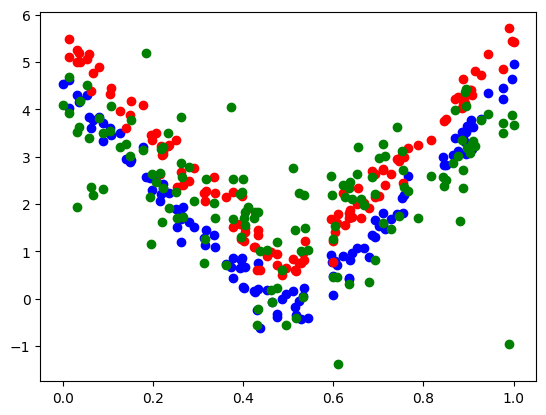

In [7]:
# plot train pred
plt.scatter(X_train[:, 0], y_train[:, 0], color='blue', label='Train Data')
plt.scatter(X_train[:, 0], y_train[:, 1], color='red', label='Train Data')
plt.scatter(X_train[:, 0], model(X_train).detach().numpy(), color='green', label='Train Prediction')

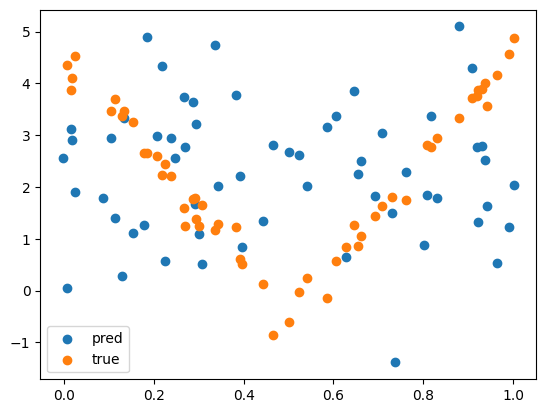

In [8]:
# plot X and y
y_test_pred = model(X_test).detach().numpy()
plt.scatter(X_test[:, 0], y_test_pred, label='pred')
plt.scatter(X_test[:, 0], y_test[:, 0], label='true')
plt.legend()